In [1]:
import edward as ed
from edward.models import Poisson,Gamma
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import helper_func
import math
import models
import scipy.special as sp
from scipy.misc import logsumexp
import gc

In [2]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

In [3]:
dataset = 'movielens'  #bibx,biby,movielens
full_X,x,test_mask = helper_func.load_data(dataset)
x = full_X
result_folder = "dual_bibtex"
metric = 'mae_nz_all'
users = x.shape[0]
items = x.shape[1]
train_non_zero_indices = helper_func.non_zero_entries(x)
score = []

In [4]:
epochs = 100
epochs += 1
test_every = 1
no_samples_mle = 5000
no_sample_inf = 50
k = 5
n_trunc = 10;
param = models.poisson_response(users,items,n_trunc);

In [5]:
eta = 0.3 #looks like n
rho =  0.3  #looks like p
zeta = 0.3 #looks like mirror inverted c
omega = 0.3 #looks like w
cutoff_loglik = np.log(1e-6);
varrho = 1.
varpi = 1.


In [6]:
ar =  np.ones(shape=(users,1))*(rho+k*eta)   # not fixed in the original code
br = np.ones(shape=(users,1))   
aw = np.ones(shape=(items,1))*(omega+k*zeta)  # not fixed in the original code
bw = np.ones(shape=(items,1))
a_s = np.random.uniform(low=0.1,size=[users,k])
bs = np.random.uniform(low=0.1,size=[users,k])
av = np.random.uniform(low=0.1,size=[items,k])
bv = np.random.uniform(low=0.1,size=[items,k])
A = np.empty(shape=[users,items])

In [7]:
param.mle_update(train_non_zero_indices,x,no_samples_mle)
del train_non_zero_indices

In [8]:
curr_iter  = 0
while curr_iter <= epochs:
    print curr_iter    
    br = rho/varrho + (a_s/bs).sum(axis=1,keepdims=True)
    bs = (ar/br).repeat(k,axis=1) + ((av/bv).sum(axis=0,keepdims=True)).repeat(users,axis=0)
    bw = omega/varpi + (av/bv).sum(axis=1,keepdims=True)
    bv = (aw/bw).repeat(k,axis=1) +((a_s/bs).sum(axis=0,keepdims=True)).repeat(items,axis=0)

    A = np.matmul((a_s/bs),(av/bv).transpose())
    en = param.expectation_mat(x,A,n_trunc)
    varphi_u = (sp.digamma(a_s)-np.log(bs)).reshape((1,users,k)).repeat(items,axis=0).swapaxes(0,1)
    varphi_i = (sp.digamma(av)-np.log(bv)).reshape((1,items,k)).repeat(users,axis=0)
    varphi = varphi_u + varphi_i
    log_norm = logsumexp(varphi,axis=2)
    varphi = np.exp(varphi-log_norm[:,:,np.newaxis])
    temp = en[:,:,np.newaxis]*varphi
    a_s = eta + temp.sum(axis=1)
    av = zeta + temp.sum(axis=0)
    
    assert np.isfinite(br).all()
    assert np.isfinite(bs).all()
    assert np.isfinite(bw).all()
    assert np.isfinite(bv).all()
    assert np.isfinite(A).all()
    assert np.isfinite(en).all()
    assert np.isfinite(varphi).all()
    assert np.isfinite(a_s).all()
    assert np.isfinite(av).all()
    gc.collect()
    
    
    if curr_iter%test_every == 0:
#         q_theta = Gamma(a_s,bs)
#         q_beta = Gamma(np.transpose(av),np.transpose(bv))
#         beta_sample = q_beta.sample(no_sample_inf).eval()
#         theta_sample = q_theta.sample(no_sample_inf).eval()    
#         score.append(helper_func.check(param,theta_sample,beta_sample,test_mask,full_X,metric=metric))
        score.append(helper_func.mae_nz_all(x,param.lam*en))
        print score[-1]
        
#         score.append(helper_func.check(param,theta_sample,beta_sample,test_mask,full_X,metric=metric))
#         ind = x.nonzero()
#         print np.sum(np.absolute(x[ind]-param.lam*en[ind]))/ind[0].size
        gc.collect()
    curr_iter += 1


0
0.943941107229
1
0.810306058572
2
0.812312877567
3
0.81220331078
4
0.81158627454
5
0.811008953789
6
0.810485679593
7
0.809947695557
8
0.809345501464
9
0.808709079174
10
0.808158652836
11
0.807975900683
12
0.808283087902
13
0.80905224427
14
0.810065554081
15
0.811020923799
16
0.811766850141
17
0.812194875653
18
0.812311953537
19
0.812290715315
20
0.812261115186
21
0.812282641212
22
0.812327504355
23
0.812313230148
24
0.812223927028
25
0.81205001726
26
0.811828470042
27
0.811605843159
28
0.811411733876
29
0.81122900726
30
0.811047766633
31
0.810867659018
32
0.810695465129
33
0.810545420082
34
0.810420236723
35
0.810314931049
36
0.810224984984
37
0.81014936884
38
0.810083434723
39
0.810024564969
40
0.809970037477
41
0.809920424544
42
0.809875882349
43
0.809835375276
44
0.809797666962
45
0.809762949257
46
0.80973065236
47
0.809700391403
48
0.809672668836
49
0.809645596747
50
0.809619765271
51
0.809595274136
52
0.809572551447
53
0.809551249933
54
0.80953231717
55
0.809515856585
56
0.80950

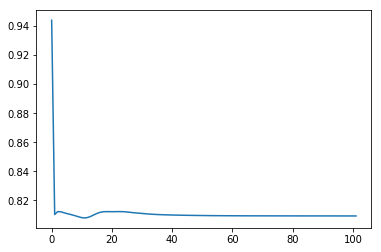

0.807975900683


In [9]:
plt.plot(score)
plt.show()
print min(score)

In [10]:
print x.nonzero()

(array([  0,   0,   0, ..., 942, 942, 942]), array([   0,    1,    2, ..., 1187, 1227, 1329]))


In [11]:
ele = 0
row = x.nonzero()[0][ele]
col = x.nonzero()[1][ele]
print x[row,col]
print param.q[row,col]
print param.q.shape

5.0
[  4.60212561e-01   4.68730062e-01   6.71351066e-02   3.79875704e-03
   1.20908234e-04   2.56554113e-06   3.99952582e-08   4.87314099e-10
   4.84153697e-12   4.04415361e-14]
(943, 1682, 10)
